# Evaluation Project -6

# Loan Application Status Prediction

In [1]:
# Importing all libraries

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno

%matplotlib inline
from scipy.stats import zscore

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

In [2]:
#loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/dsrscientist/DSData/master/loan_prediction.csv')
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


We see that dataset has 614 rows and 13 columns.<br>
We have mixed kind of data both numerical and categorical.<br>
Loan_Status is our target variable which has two classes which makes this problem a classification one.

# EDA

In [3]:
df.shape

(614, 13)

614 rows and 13 columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


We can see counts of all columns is not same which indicated missing values.<br>
Float datatype columns are 4.<br>
interger datatype colums are 1.<br>
Object datatype columns are 8.

In [5]:
#droppin column load_id as it does not affect our target variable 
df.drop("Loan_ID", axis=1, inplace=True)

In [6]:
# dividing columns in object and integer data
# getting list of object data type column names
obj_d = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'object':
        obj_d.append(x)
print(f"Object Data Type Columns are: ", obj_d)


# getting the list of float data type column names
num_d = []
for x in df.dtypes.index:
    if df.dtypes[x]=='int64'or  df.dtypes[x]=='float64':
        num_d.append(x)
print(f"Integer Data Type Columns are: ", num_d)

Object Data Type Columns are:  ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
Integer Data Type Columns are:  ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


# Checking Null values

In [7]:
df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

<AxesSubplot:>

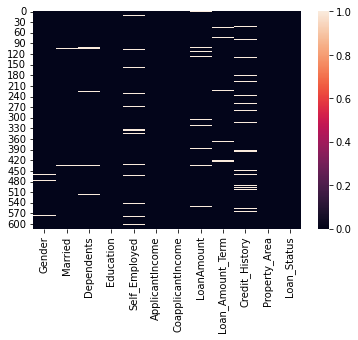

In [8]:
sns.heatmap(df.isnull())

We have got missing values in following columns:
• Gender<br>
• Married<br>
• Dependents<br>
• Self_Employed<br>
• LoanAmount<br>
• Credit_History

In [9]:
df.describe().T   # descriptive statistics of numerical data

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


• Count column has different values indicating missing values.<br>
• Mean> Median : ApplicantIncome, CoapplicantIncome, LoanAmount. This columns are right skewed.<br>
• Median> Mean : Credit_history. This is left skewed.<br>
• Large difference between 75% and Max values shows presence if outliers. Except Credit_History every column has outliers.<br>
• Some columns have minimum value zero, but its acceptable as income can be zero for students and credit history can be zero for new applicants

# Checking Duplicates

In [10]:
df.duplicated().sum()

0

We have **zero** duplicate values in our dataset

# Checking Unique Values

In [11]:
df.nunique().to_frame("Unique Values")

,Unique Values
Gender,2
Married,2
Dependents,4
Education,2
Self_Employed,2
ApplicantIncome,505
CoapplicantIncome,287
LoanAmount,203
Loan_Amount_Term,10
Credit_History,2


# Values Counts 

In [12]:
for i in df:
    print(i)
    print(df[i].value_counts())
    print('\n')
    print('*'*100)

Gender
Male      489
Female    112
Name: Gender, dtype: int64


****************************************************************************************************
Married
Yes    398
No     213
Name: Married, dtype: int64


****************************************************************************************************
Dependents
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64


****************************************************************************************************
Education
Graduate        480
Not Graduate    134
Name: Education, dtype: int64


****************************************************************************************************
Self_Employed
No     500
Yes     82
Name: Self_Employed, dtype: int64


****************************************************************************************************
ApplicantIncome
2500    9
4583    6
6000    6
2600    6
3333    5
       ..
3244    1
4408    1
3917    1
3992    1
7583    1
Name: A

# Filling Null Vlaues

In [13]:
# filling missing values of categorical columns
df['Gender'].fillna(df['Gender'].mode()[0], inplace =True)
df['Married'].fillna(df['Married'].mode()[0], inplace =True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace =True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace =True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace =True)

#filling missing values of numerical data
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace =True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean(), inplace =True)


In [14]:
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

<AxesSubplot:>

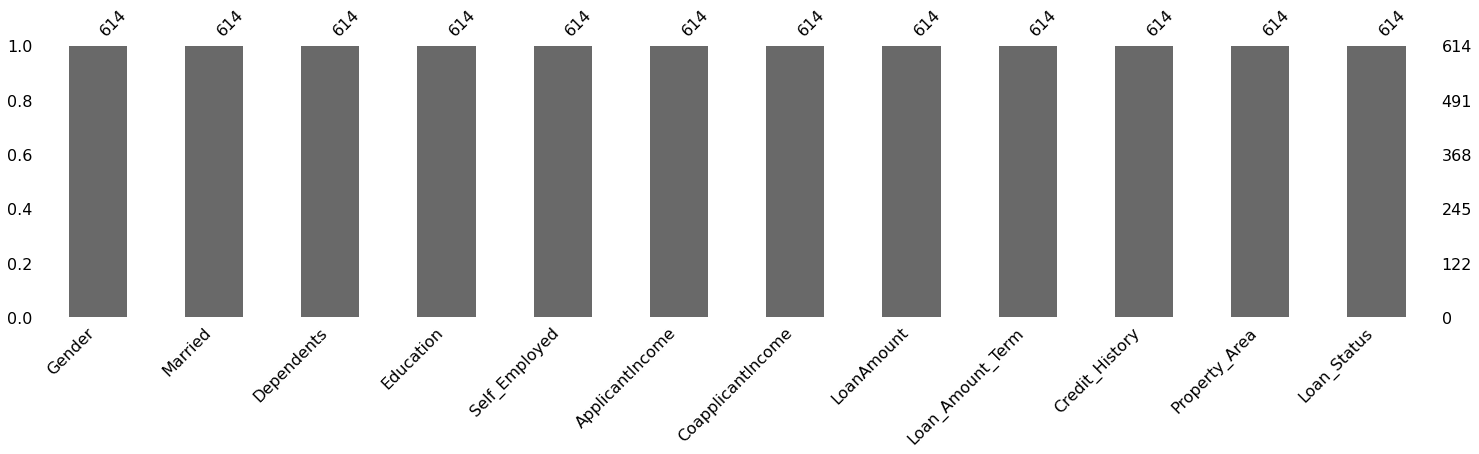

In [15]:
missingno.bar(df, figsize = (25,5))

Hence we have no missing values now

# Visualizations

**Univariate Analysis**

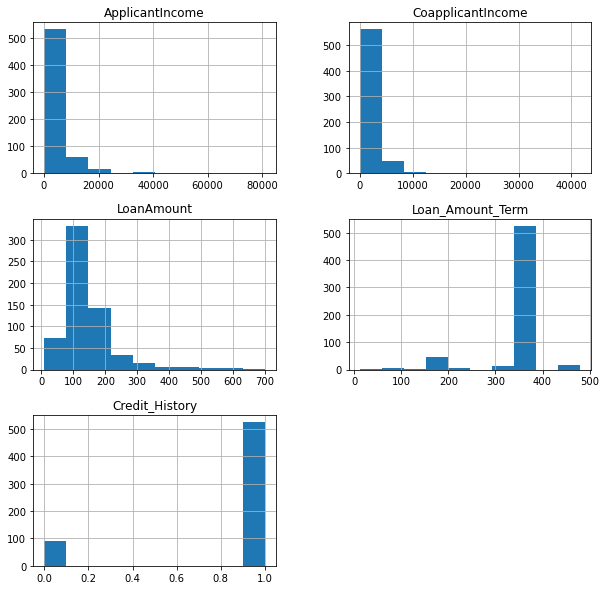

In [16]:
df.hist(figsize=(10,10))
plt.show()

In above plot we see distribution of different numerical columns 
We can see applicant income varies from 0- 20000
Coapplicant income varies from 0- 9000

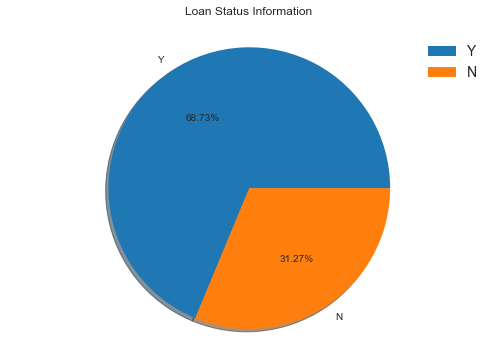

In [17]:
plt.style.use('seaborn-white')
plt.figure(figsize=(7,5))
plt.pie(df['Loan_Status'].value_counts(), labels=df['Loan_Status'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Loan Status Information\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

We see that 68.73% loan status is approved while 31.27% times it is not approved

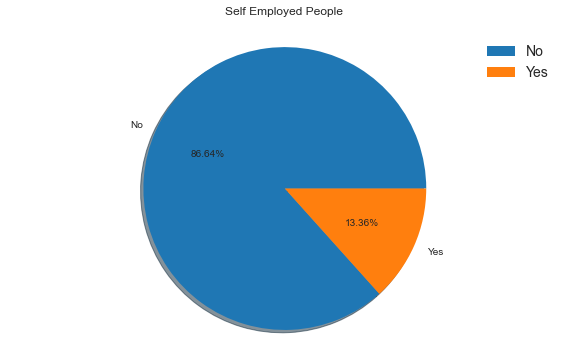

In [18]:
plt.figure(figsize=(8,5))
plt.pie(df['Self_Employed'].value_counts(), labels=df['Self_Employed'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Self Employed People\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()


Only 13.36% person are self employeed rest 86.64% are not self employed

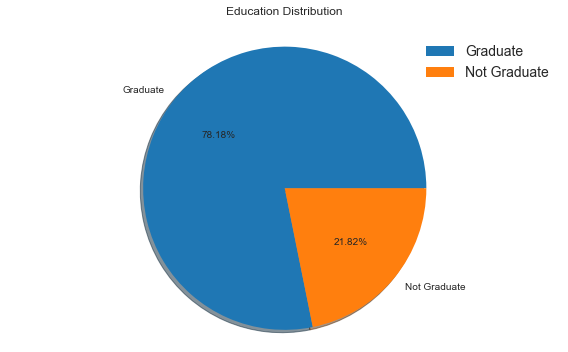

In [19]:
plt.figure(figsize=(8,5))
plt.pie(df['Education'].value_counts(), labels=df['Education'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Education Distribution\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

Graduate people tend to take more loan than non-graduates

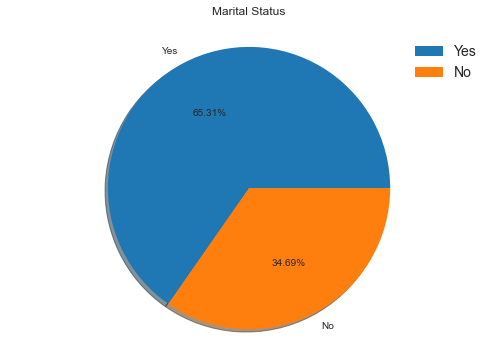

In [20]:
plt.figure(figsize=(7,5))
plt.pie(df['Married'].value_counts(), labels=df['Married'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Marital Status\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

Married people are more than unmarried

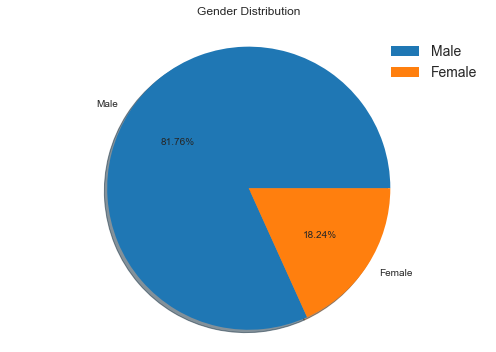

In [21]:
plt.figure(figsize=(7,5))
plt.pie(df['Gender'].value_counts(), labels=df['Gender'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Gender Distribution\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

Male tend to take more loan than female. In above pie chart we see that against 81.76% male only 18.24% female take loan.

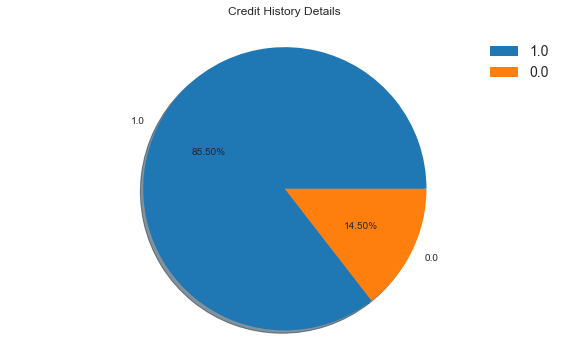

In [22]:
plt.figure(figsize=(8,5))
plt.pie(df['Credit_History'].value_counts(), labels=df['Credit_History'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Credit History Details\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

85.50% loan applicats credit history is available agains 14.50% of loan applicants whose credit history is not available.

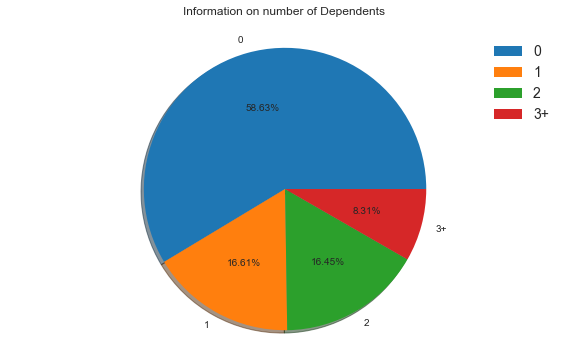

In [23]:
plt.figure(figsize=(8,5))
plt.pie(df['Dependents'].value_counts(), labels=df['Dependents'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Information on number of Dependents\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

58.63% loan applicants have 0 dependents, while having 1 dependent is 16.61%, having 2 dpendents has 16.45% and havinf 3+ dependent are 8.31%

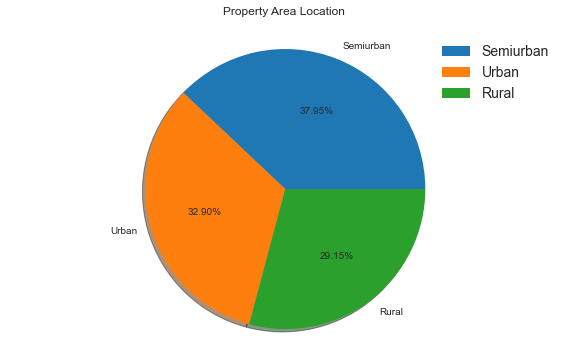

In [24]:
plt.figure(figsize=(8,5))
plt.pie(df['Property_Area'].value_counts(), labels=df['Property_Area'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Property Area Location\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

37.95% loan applicants have property area in Semiurban area, followed by 32.90% applicants have property in urban area and 29.15% loan applicants have property in rural area.

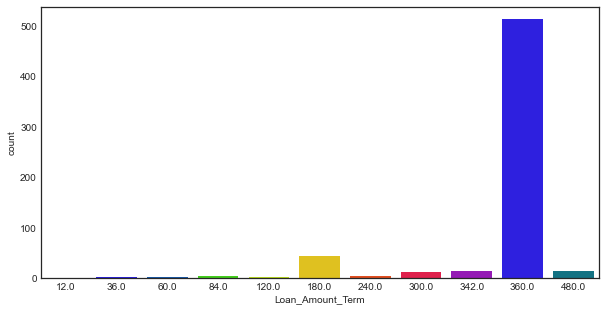

In [25]:
try:
    plt.figure(figsize=(10,5))
    col_name = 'Loan_Amount_Term'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")
    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    pass

In the above count plot we can see that the highest number of rows are covered by the value 360.0 in the "Loan_Amount_Term" column.

**Bivariate Analysis**

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

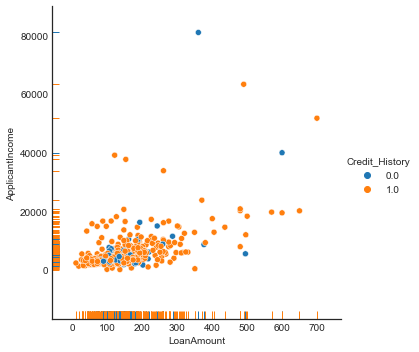

In [26]:
sns.relplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Credit_History', legend=False)

In above plot one can see we have got credit history for almost every loanAmount and Applicant Income

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

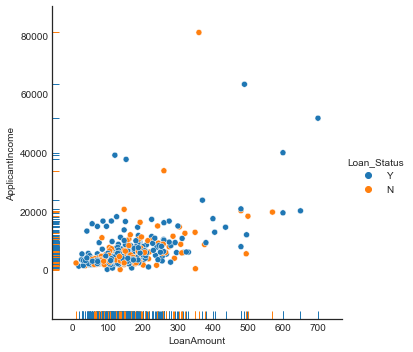

In [27]:
sns.relplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Loan_Status', legend=False)


In above plot we see with applicant income ranging from 0- 20000 are mostly given LoanAmount ranging from 50 - 250 and for those who are having income 40000 or above are given higher loan amount near to 600 

<AxesSubplot:xlabel='LoanAmount', ylabel='CoapplicantIncome'>

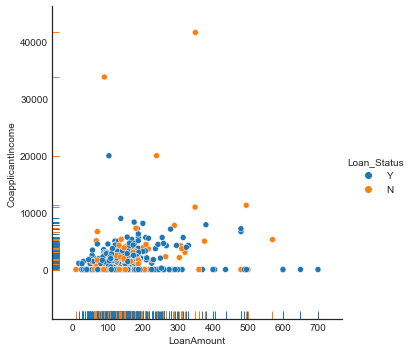

In [28]:
sns.relplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Loan_Status', legend=False)

In the above plot we see where in co applicants with higher income are mostly denied loan and where most data values are converged between 0-10000 for co applicant income and 0-300 for loan amount data

<AxesSubplot:xlabel='LoanAmount', ylabel='CoapplicantIncome'>

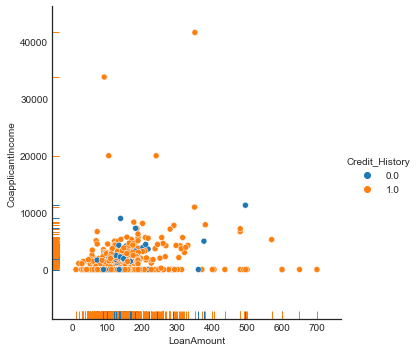

In [29]:
sns.relplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Credit_History', legend=False)

In above plot we see that credit history is availabel for almost every loan amount and co-applicant income

<AxesSubplot:xlabel='LoanAmount', ylabel='Loan_Amount_Term'>

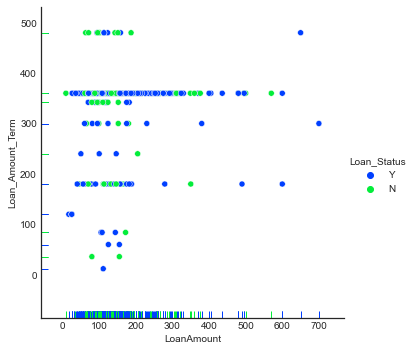

In [30]:
plt.style.use('seaborn-bright')
sns.relplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Loan_Status', legend=False)

we can see that most of the data points are accumulated for 180, 300, 340, 360 and 480 terms while loan amount ranging from 50-250 for a term of 480 mostly seems to be getting approved.

<AxesSubplot:xlabel='LoanAmount', ylabel='Loan_Amount_Term'>

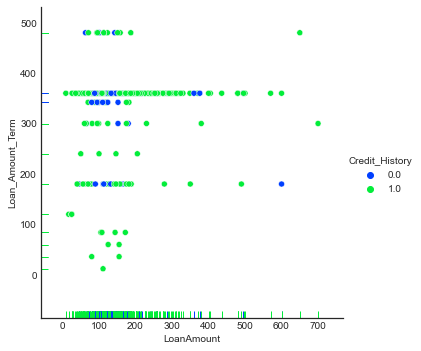

In [31]:
sns.relplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Credit_History', legend=False)

Here we see Loan amount ranging from 50 -350 has got credit history. And Loan_amount_term for value 180, 300, 370, 480 has got maximum credit history

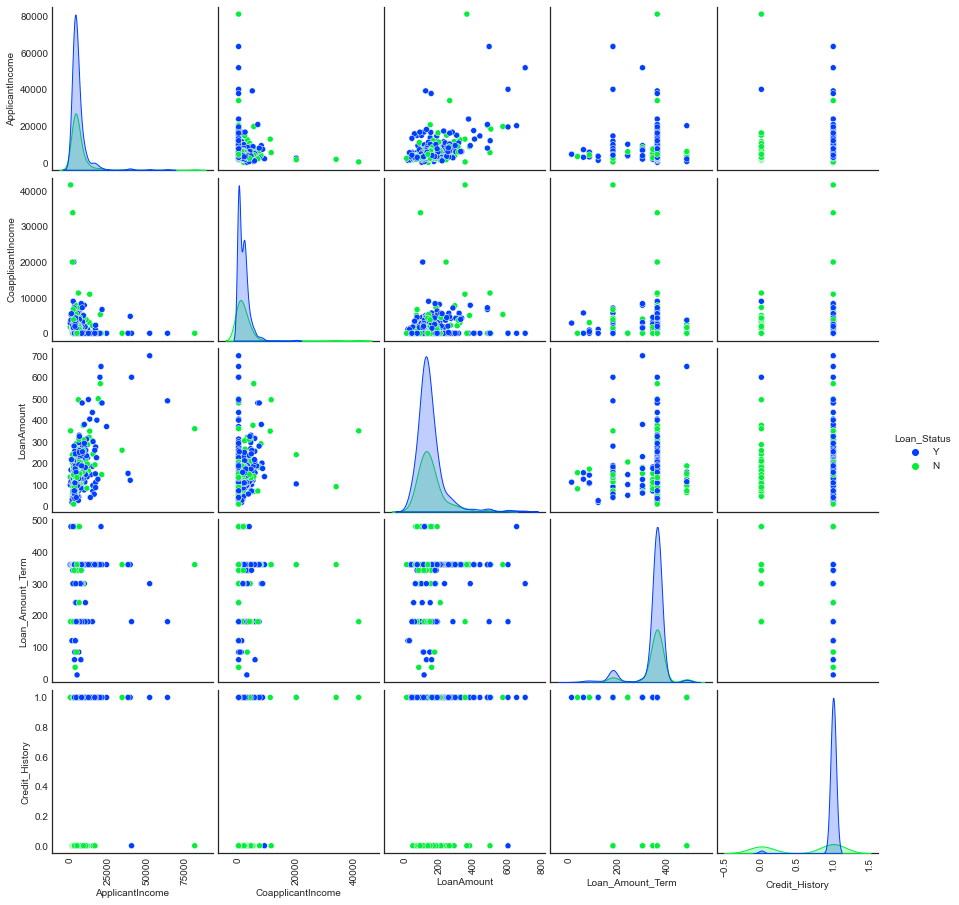

In [32]:
g = sns.pairplot(df, hue='Loan_Status', diag_kind='kde')
for ax in g.axes.flat:
    ax.tick_params("x", labelrotation=90)
plt.show()

I have generated the above pairplot for our continous data columns that shows us how the data points are distributed in each of the numeric datatype columns.

# Encoding

In [33]:
# using label encoder for target column
le = LabelEncoder()
df['Loan_Status'] = le.fit_transform(df['Loan_Status'])

# using ordinal encoder for feature columns

oe = OrdinalEncoder()
df['Gender'] = oe.fit_transform(df['Gender'].values.reshape(-1,1))
df['Married'] = oe.fit_transform(df['Married'].values.reshape(-1,1))
df['Education'] = oe.fit_transform(df['Education'].values.reshape(-1,1))
df['Self_Employed'] = oe.fit_transform(df['Self_Employed'].values.reshape(-1,1))
df['Property_Area'] = oe.fit_transform(df['Property_Area'].values.reshape(-1,1))
df['Dependents'] = oe.fit_transform(df['Dependents'].values.reshape(-1,1))

In [34]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1.0,0.0,0.0,0.0,0.0,5849,0.0,146.412162,360.0,1.0,2.0,1
1,1.0,1.0,1.0,0.0,0.0,4583,1508.0,128.000000,360.0,1.0,0.0,0
2,1.0,1.0,0.0,0.0,1.0,3000,0.0,66.000000,360.0,1.0,2.0,1
3,1.0,1.0,0.0,1.0,0.0,2583,2358.0,120.000000,360.0,1.0,2.0,1
4,1.0,0.0,0.0,0.0,0.0,6000,0.0,141.000000,360.0,1.0,2.0,1


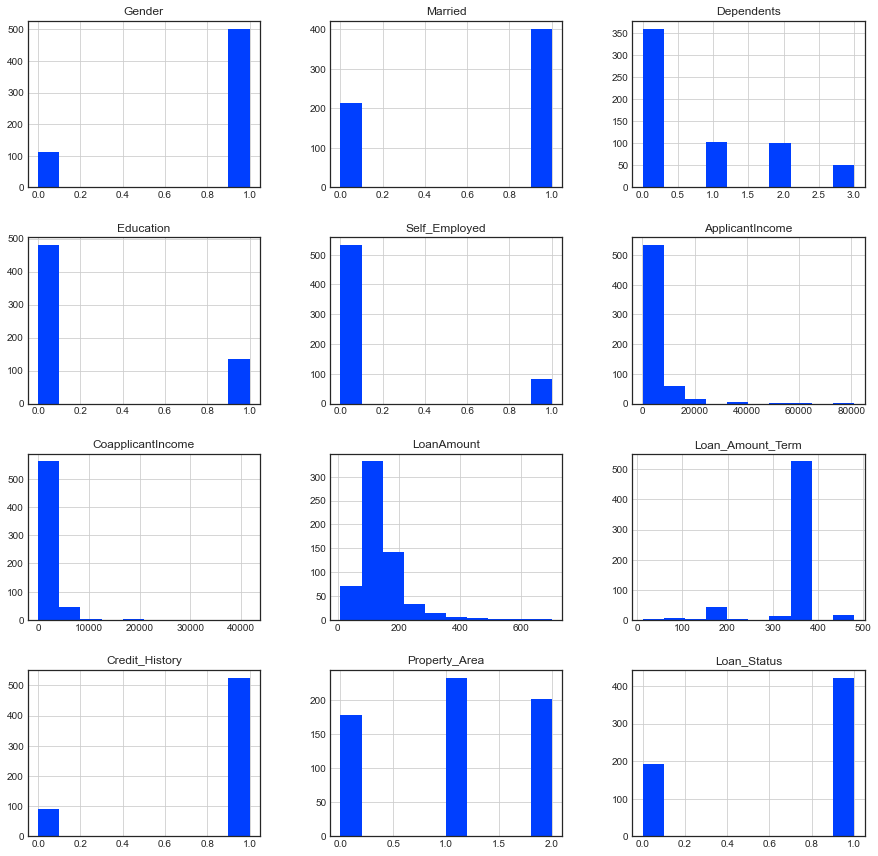

In [35]:
df.hist(figsize=(15,15))
plt.show()

From above we can see how data points are distributed after encoding the categorical columns.<br>


# Correlation

In [36]:
df.corr()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Gender,1.000000,0.364569,0.172914,0.045364,-0.000525,0.058809,0.082912,0.107930,-0.073567,0.009170,-0.025752,0.017987
Married,0.364569,1.000000,0.334216,0.012304,0.004489,0.051708,0.075948,0.147141,-0.100863,0.010938,0.004257,0.091478
Dependents,0.172914,0.334216,1.000000,0.055752,0.056798,0.118202,0.030430,0.163106,-0.101054,-0.040160,-0.000244,0.010118
Education,0.045364,0.012304,0.055752,1.000000,-0.010383,-0.140760,-0.062290,-0.166998,-0.077242,-0.073658,-0.065243,-0.085884
Self_Employed,-0.000525,0.004489,0.056798,-0.010383,1.000000,0.127180,-0.016100,0.115260,-0.033943,-0.001550,-0.030860,-0.003700
ApplicantIncome,0.058809,0.051708,0.118202,-0.140760,0.127180,1.000000,-0.116605,0.565620,-0.045242,-0.018615,-0.009500,-0.004710
CoapplicantIncome,0.082912,0.075948,0.030430,-0.062290,-0.016100,-0.116605,1.000000,0.187828,-0.059675,0.011134,0.010522,-0.059187
LoanAmount,0.107930,0.147141,0.163106,-0.166998,0.115260,0.565620,0.187828,1.000000,0.038801,-0.001431,-0.044776,-0.036416
Loan_Amount_Term,-0.073567,-0.100863,-0.101054,-0.077242,-0.033943,-0.045242,-0.059675,0.038801,1.000000,0.000432,-0.077620,-0.020974
Credit_History,0.009170,0.010938,-0.040160,-0.073658,-0.001550,-0.018615,0.011134,-0.001431,0.000432,1.000000,0.001963,0.540556


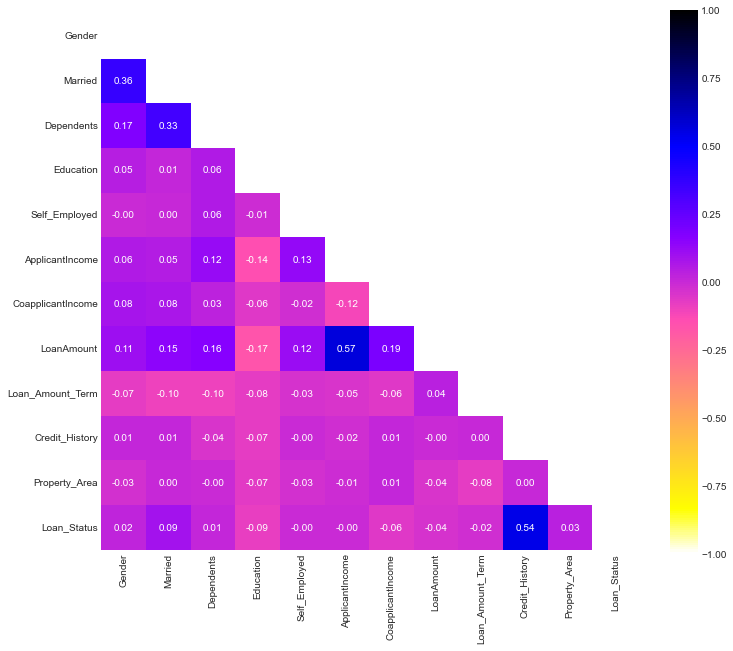

In [37]:
plt.style.use('seaborn-pastel')
ut = np.triu(df.corr())
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.2f', 
            annot_kws={'size':10}, cmap="gnuplot2_r", mask=ut)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

We have plotted correlation triangle for better understanding.<br>
Highly correlated with Loan_status are Credit_history, MArried.<br>
Not at all correlated are applicantIncome, Self employed.<br>


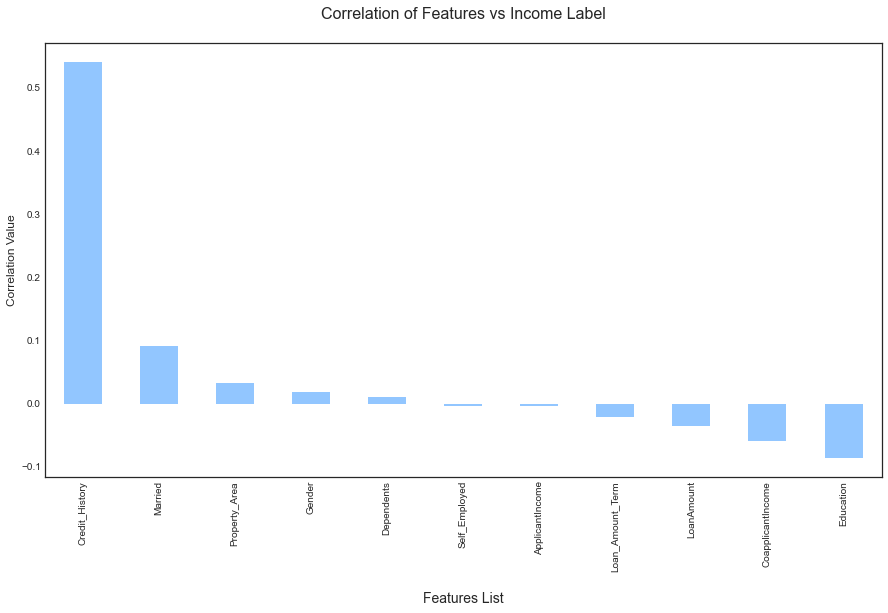

In [38]:
# plotting bar plot of correlation
plt.style.use('seaborn-white')
df_corr = df.corr()
plt.figure(figsize=(15,8))
df_corr['Loan_Status'].sort_values(ascending=False).drop('Loan_Status').plot.bar()
plt.title("Correlation of Features vs Income Label\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value", fontsize=12)
plt.show()

As we can see credit_history is most correlated with positive correlation, followed by negaitve correlation with education.


# Checking And Removing Outliers

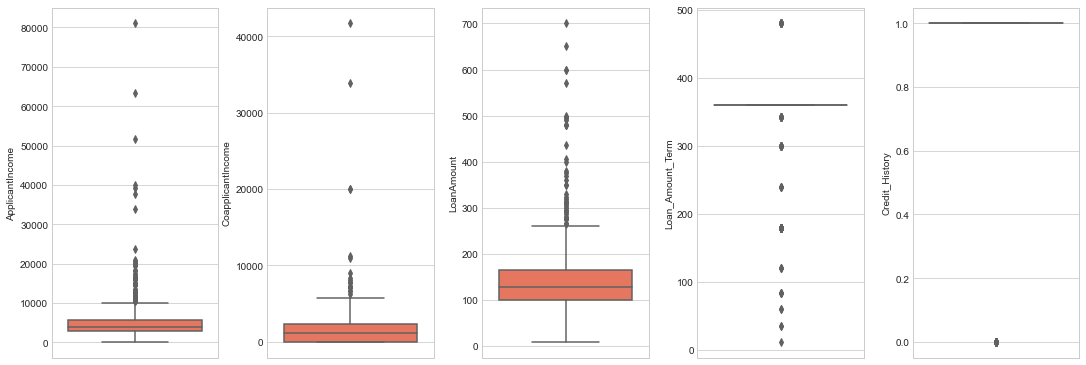

In [39]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
index =0

ax=ax.flatten()

for col, value in df[num_d].items():
    sns.boxplot(y =col, data= df, ax = ax[index], palette= "Reds")
    index+=1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

We can plotting box plot the presence of outliers in our numerical data.<br>
Outliers are present in every numerical column and needs to be treated.


**Removing Outliers**

In [40]:
z = np.array(abs(zscore(df)))
threshold = 3
print(np.where(z>3))

(array([  9,  14,  68,  94, 126, 130, 133, 155, 155, 171, 171, 177, 177,
       183, 185, 242, 262, 278, 308, 313, 333, 333, 369, 402, 409, 417,
       432, 443, 487, 495, 497, 506, 523, 525, 546, 561, 575, 581, 585,
       600, 604], dtype=int64), array([6, 8, 8, 8, 5, 7, 8, 5, 7, 5, 7, 6, 7, 5, 5, 8, 8, 7, 7, 8, 5, 7,
       7, 6, 5, 6, 7, 5, 7, 8, 8, 7, 7, 7, 8, 7, 8, 6, 8, 6, 7],
      dtype=int64))


In [41]:
df_new =df[(z<3).all(axis=1)]
df_new

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1.0,0.0,0.0,0.0,0.0,5849,0.0,146.412162,360.0,1.0,2.0,1
1,1.0,1.0,1.0,0.0,0.0,4583,1508.0,128.000000,360.0,1.0,0.0,0
2,1.0,1.0,0.0,0.0,1.0,3000,0.0,66.000000,360.0,1.0,2.0,1
3,1.0,1.0,0.0,1.0,0.0,2583,2358.0,120.000000,360.0,1.0,2.0,1
4,1.0,0.0,0.0,0.0,0.0,6000,0.0,141.000000,360.0,1.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.0,0.0,0.0,0.0,0.0,2900,0.0,71.000000,360.0,1.0,0.0,1
610,1.0,1.0,3.0,0.0,0.0,4106,0.0,40.000000,180.0,1.0,0.0,1
611,1.0,1.0,1.0,0.0,0.0,8072,240.0,253.000000,360.0,1.0,2.0,1
612,1.0,1.0,2.0,0.0,0.0,7583,0.0,187.000000,360.0,1.0,2.0,1


In [42]:
print("Old dataframe shape :",df.shape)
print("New dataframe shape :", df_new.shape)
dataloss = ((614-577)/614)*100
print("Percentage data loss is :", dataloss)

Old dataframe shape : (614, 12)
New dataframe shape : (577, 12)
Percentage data loss is : 6.026058631921824


We have loss 6.02% data in removing outliers which is less than 10 %, so its affordable

In [43]:
df = df_new.copy()                                # I am copying the new changes to my old dataframe

# Checking Skewness

In [44]:
df.skew().sort_values()

Loan_Amount_Term    -2.077031
Credit_History      -1.976043
Gender              -1.622920
Loan_Status         -0.822635
Married             -0.630211
Property_Area       -0.055332
Dependents           1.052106
LoanAmount           1.113132
Education            1.306588
CoapplicantIncome    1.350517
ApplicantIncome      2.148522
Self_Employed        2.252848
dtype: float64

Ignoring the encoded columns almost every column is skewed. Lets check it graphically

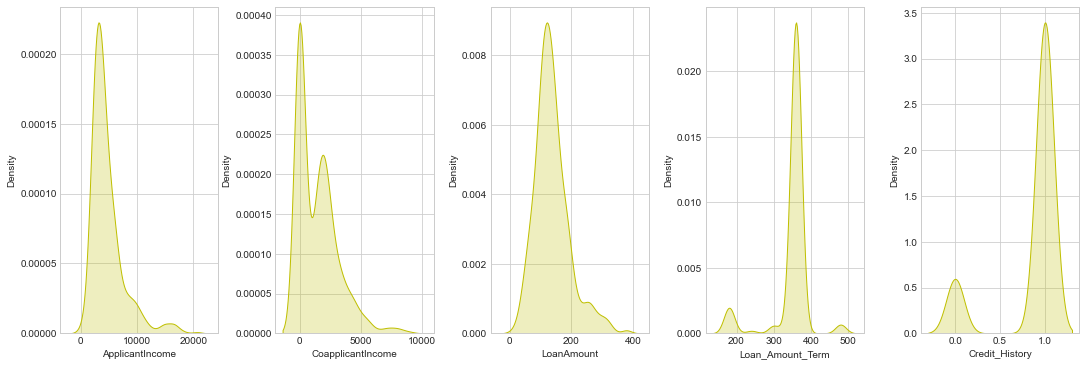

In [45]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[num_d].items():
    sns.distplot(value, ax=ax[index], hist=False, color="y", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

ApplicantIncome is right skewed.<br>
Credit_history and CoapplicantIncome are bimodal.<br>
Loan_amount is right skewed.<br>


# Splitting the Dataframe in target and feature variables

In [46]:
x = df.drop('Loan_Status', axis=1)
y=df['Loan_Status']

# Removing Skewness

In [47]:
from sklearn.preprocessing import PowerTransformer
power_t = PowerTransformer(method = 'yeo-johnson')
x = pd.DataFrame(power_t.fit_transform(x), columns=x.columns)
x

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0.477137,-1.362511,-0.809243,-0.541961,-0.380580,0.681780,-1.122446,0.316078,0.142609,0.418513,1.194806
1,0.477137,0.733939,0.902869,-0.541961,-0.380580,0.234783,0.744117,-0.015871,0.142609,0.418513,-1.340199
2,0.477137,0.733939,-0.809243,-0.541961,2.627567,-0.527201,-1.122446,-1.443112,0.142609,0.418513,1.194806
3,0.477137,0.733939,-0.809243,1.845150,-0.380580,-0.791972,0.895786,-0.169860,0.142609,0.418513,1.194806
4,0.477137,-1.362511,-0.809243,-0.541961,-0.380580,0.728848,-1.122446,0.221481,0.142609,0.418513,1.194806
...,...,...,...,...,...,...,...,...,...,...,...
572,-2.095835,-1.362511,-0.809243,-0.541961,-0.380580,-0.587375,-1.122446,-1.301481,0.142609,0.418513,-1.340199
573,0.477137,0.733939,1.533596,-0.541961,-0.380580,0.035386,-1.122446,-2.321865,-2.559206,0.418513,-1.340199
574,0.477137,0.733939,0.902869,-0.541961,-0.380580,1.281658,0.173344,1.838099,0.142609,0.418513,1.194806
575,0.477137,0.733939,1.344671,-0.541961,-0.380580,1.164426,-1.122446,0.961555,0.142609,0.418513,1.194806


In [48]:
x.skew().sort_values()

Credit_History      -1.976043
Gender              -1.622920
Married             -0.630211
CoapplicantIncome   -0.191876
Property_Area       -0.155094
ApplicantIncome      0.027981
LoanAmount           0.047692
Dependents           0.478360
Loan_Amount_Term     0.718470
Education            1.306588
Self_Employed        2.252848
dtype: float64

Ignoring the skewness of encoded columns we have managed to reduced the skewness to desired level.

# Multicollinearity

In [49]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [50]:
def calc_vif(x):
    vif=pd.DataFrame()
    vif['variables']=x.columns
    vif["VIF FACTOR"]= [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
    return(vif)

calc_vif(x)

,variables,VIF FACTOR
0,Gender,1.219265
1,Married,1.433527
2,Dependents,1.184111
3,Education,1.065654
4,Self_Employed,1.055700
5,ApplicantIncome,1.764886
6,CoapplicantIncome,1.577502
7,LoanAmount,1.546562
8,Loan_Amount_Term,1.048603
9,Credit_History,1.008795


Every columns has VIF factor below 10 which is permissible so we can proceed

# Balancing the data using SMOTE

<AxesSubplot:xlabel='Loan_Status', ylabel='count'>

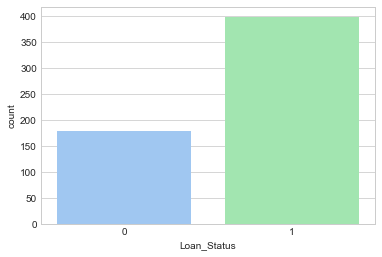

In [51]:
sns.countplot(y)

As we can see our target variable has imbalanced data which need to be balanced for proper predictions and training of models

In [52]:
sm = SMOTE()
x,y = sm.fit_resample(x, y)

<AxesSubplot:xlabel='Loan_Status', ylabel='count'>

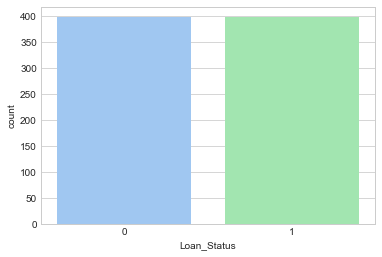

In [53]:
sns.countplot(y)

Thus after using SMOTE technique I was able to balance my data

In [54]:
x.shape

(796, 11)

In [55]:
y.shape

(796,)

# Scaling the Data

In [56]:
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
x.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0.46613,-1.339277,-0.845583,-0.559543,-0.386360,0.709787,-1.093151,0.329424,0.113383,0.546757,1.213715
1,0.46613,0.756978,0.892882,-0.559543,-0.386360,0.233413,0.794170,-0.007870,0.113383,0.546757,-1.321856
2,0.46613,0.756978,-0.845583,-0.559543,2.645861,-0.578647,-1.093151,-1.458091,0.113383,0.546757,1.213715
3,0.46613,0.756978,-0.845583,1.855017,-0.386360,-0.860819,0.947526,-0.164339,0.113383,0.546757,1.213715
4,0.46613,-1.339277,-0.845583,-0.559543,-0.386360,0.759948,-1.093151,0.233303,0.113383,0.546757,1.213715


# Finding the Best Random State

In [60]:
max_Accu=0
max_RS=0

for i in range(1, 1000):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=i)
    lr=LogisticRegression()
    lr.fit(x_train, y_train)
    pred = lr.predict(x_test)
    acc_score = (accuracy_score(y_test, pred))*100
    
    if acc_score>max_Accu:
        max_Accu=acc_score
        max_RS=i

print("Best accuracy score is", max_Accu,"on Random State", max_RS)

Best accuracy score is 79.375 on Random State 154


Hence we got our random state as 154

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=154)

# Feature Importance Bar Graph

,Importance
Features,
Credit_History,0.226
ApplicantIncome,0.180
LoanAmount,0.177
CoapplicantIncome,0.123
Property_Area,0.096
Dependents,0.073
Loan_Amount_Term,0.036
Education,0.028
Married,0.024


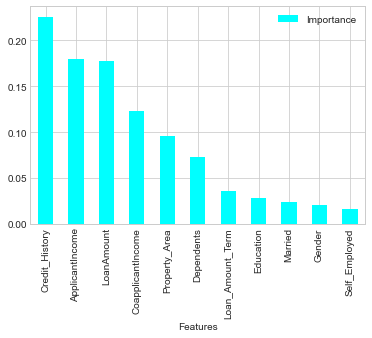

In [62]:
rf=RandomForestClassifier()
rf.fit(x_train, y_train)
importances = pd.DataFrame({'Features':x.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances.plot.bar(color='cyan')
importances

Among all features Credit_history is at highest priority, followed by ApplicantIncome, LoanAmount and so on

# Training the various models

LogisticRegression()
Accuracy Score of LogisticRegression() is: 79.375
Cross Validation Score are : [0.70175439 0.71929825 0.73684211 0.6754386  0.70175439 0.7079646
 0.74336283]
Cross Validation Score: 74.33628318584071
Accuracy Score - CV_Score 5.038716814159287
[[47 29]
 [ 4 80]]
              precision    recall  f1-score   support

           0       0.92      0.62      0.74        76
           1       0.73      0.95      0.83        84

    accuracy                           0.79       160
   macro avg       0.83      0.79      0.78       160
weighted avg       0.82      0.79      0.79       160

AUC Score of  LogisticRegression() is 0.7854010025062657


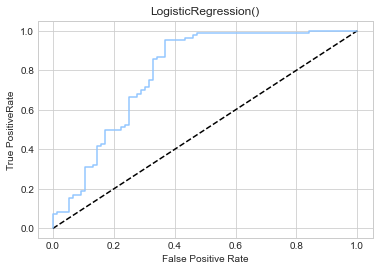



************************************************************************************************************************
GaussianNB()
Accuracy Score of GaussianNB() is: 78.75
Cross Validation Score are : [0.71052632 0.68421053 0.74561404 0.69298246 0.69298246 0.76106195
 0.74336283]
Cross Validation Score: 76.10619469026548
Accuracy Score - CV_Score 2.6438053097345176
[[44 32]
 [ 2 82]]
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        76
           1       0.72      0.98      0.83        84

    accuracy                           0.79       160
   macro avg       0.84      0.78      0.77       160
weighted avg       0.83      0.79      0.78       160

AUC Score of  GaussianNB() is 0.7775689223057645


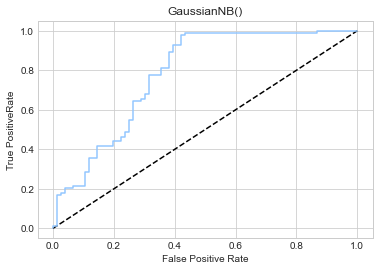



************************************************************************************************************************
DecisionTreeClassifier()
Accuracy Score of DecisionTreeClassifier() is: 76.25
Cross Validation Score are : [0.70175439 0.71052632 0.78070175 0.79824561 0.74561404 0.83185841
 0.80530973]
Cross Validation Score: 83.1858407079646
Accuracy Score - CV_Score -6.935840707964601
[[66 10]
 [28 56]]
              precision    recall  f1-score   support

           0       0.70      0.87      0.78        76
           1       0.85      0.67      0.75        84

    accuracy                           0.76       160
   macro avg       0.78      0.77      0.76       160
weighted avg       0.78      0.76      0.76       160

AUC Score of  DecisionTreeClassifier() is 0.7675438596491228


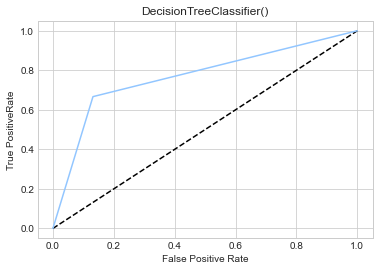



************************************************************************************************************************
KNeighborsClassifier()
Accuracy Score of KNeighborsClassifier() is: 74.375
Cross Validation Score are : [0.76315789 0.76315789 0.76315789 0.78947368 0.74561404 0.7079646
 0.71681416]
Cross Validation Score: 78.94736842105263
Accuracy Score - CV_Score -4.57236842105263
[[60 16]
 [25 59]]
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        76
           1       0.79      0.70      0.74        84

    accuracy                           0.74       160
   macro avg       0.75      0.75      0.74       160
weighted avg       0.75      0.74      0.74       160

AUC Score of  KNeighborsClassifier() is 0.7459273182957393


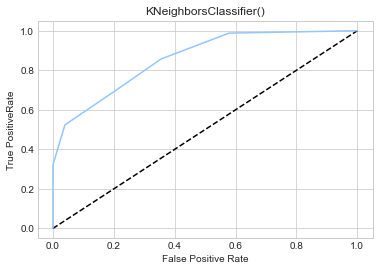



************************************************************************************************************************
RandomForestClassifier()
Accuracy Score of RandomForestClassifier() is: 84.375
Cross Validation Score are : [0.73684211 0.73684211 0.81578947 0.90350877 0.86842105 0.92920354
 0.92035398]
Cross Validation Score: 92.92035398230088
Accuracy Score - CV_Score -8.545353982300881
[[60 16]
 [ 9 75]]
              precision    recall  f1-score   support

           0       0.87      0.79      0.83        76
           1       0.82      0.89      0.86        84

    accuracy                           0.84       160
   macro avg       0.85      0.84      0.84       160
weighted avg       0.85      0.84      0.84       160

AUC Score of  RandomForestClassifier() is 0.8411654135338346


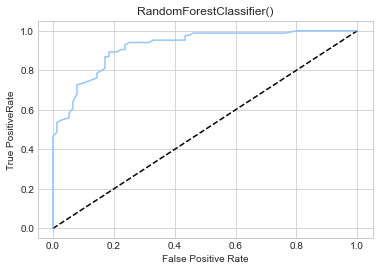



************************************************************************************************************************
SVC(probability=True)
Accuracy Score of SVC(probability=True) is: 79.375
Cross Validation Score are : [0.71052632 0.71929825 0.73684211 0.70175439 0.72807018 0.75221239
 0.7699115 ]
Cross Validation Score: 76.99115044247787
Accuracy Score - CV_Score 2.383849557522126
[[53 23]
 [10 74]]
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        76
           1       0.76      0.88      0.82        84

    accuracy                           0.79       160
   macro avg       0.80      0.79      0.79       160
weighted avg       0.80      0.79      0.79       160

AUC Score of  SVC(probability=True) is 0.7891604010025063


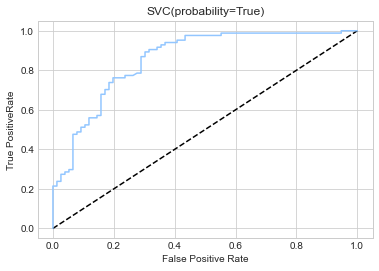



************************************************************************************************************************
ExtraTreesClassifier()
Accuracy Score of ExtraTreesClassifier() is: 87.5
Cross Validation Score are : [0.80701754 0.75438596 0.81578947 0.90350877 0.85087719 0.91150442
 0.84955752]
Cross Validation Score: 91.1504424778761
Accuracy Score - CV_Score -3.6504424778760978
[[63 13]
 [ 7 77]]
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        76
           1       0.86      0.92      0.89        84

    accuracy                           0.88       160
   macro avg       0.88      0.87      0.87       160
weighted avg       0.88      0.88      0.87       160

AUC Score of  ExtraTreesClassifier() is 0.8728070175438596


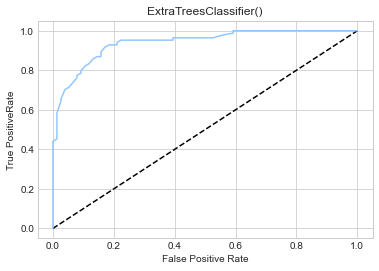



************************************************************************************************************************
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Accuracy Score of XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_s

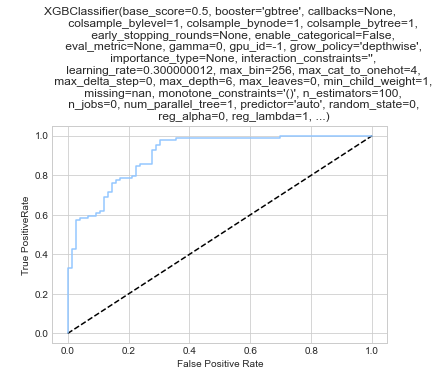



************************************************************************************************************************
LGBMClassifier()
Accuracy Score of LGBMClassifier() is: 80.625
Cross Validation Score are : [0.70175439 0.74561404 0.79824561 0.86842105 0.84210526 0.86725664
 0.86725664]
Cross Validation Score: 86.8421052631579
Accuracy Score - CV_Score -6.2171052631579045
[[61 15]
 [16 68]]
              precision    recall  f1-score   support

           0       0.79      0.80      0.80        76
           1       0.82      0.81      0.81        84

    accuracy                           0.81       160
   macro avg       0.81      0.81      0.81       160
weighted avg       0.81      0.81      0.81       160

AUC Score of  LGBMClassifier() is 0.806077694235589


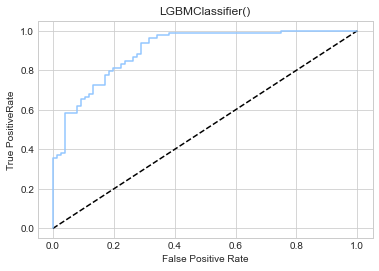



************************************************************************************************************************


In [63]:
lg=LogisticRegression()
gnb=GaussianNB()
svc=SVC(probability=True)
dtc =DecisionTreeClassifier()
knn= KNeighborsClassifier()
rfc= RandomForestClassifier()
etc = ExtraTreesClassifier()
xg= xgb.XGBClassifier(verbosity = 0)
LGBM = lgb.LGBMClassifier()

model=[lg,gnb,dtc,knn,rfc,svc,etc,xg,LGBM]

for m in model:
    m.fit(x_train,y_train)
    m.score(x_train,y_train)
    predm=m.predict(x_test)
    
    #Calculating cross validation score
    for i in range(2,8):
        cvs=cross_val_score(m,x,y,cv=i)
    
    a = max(cvs)
    cv_score=(a.mean())*100      # taking max value of cvs and calculating mean of it    
# taking max value because I am assuming that accuracy score of all models to be approx 100 %
    
    
    y_pred_prob = m.predict_proba(x_test)[:,-1]
    fpr,tpr,thresholds = roc_curve(y_test, y_pred_prob)
    auc_score = roc_auc_score(y_test, m.predict(x_test))
    print(m)
    print('Accuracy Score of',m,'is:',accuracy_score(y_test,predm)*100)
    print("Cross Validation Score are :", cvs)
    print("Cross Validation Score:", cv_score)
    print("Accuracy Score - CV_Score", (accuracy_score(y_test,predm)*100)-(cv_score))
    print(confusion_matrix(y_test,predm))
    print(classification_report(y_test,predm))
    print("AUC Score of ",m,"is",auc_score)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr,tpr,label=m)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True PositiveRate")
    plt.title(m)
    plt.show()
    print('\n')
    print('*'*120)

Lets plot a performance table to jot down every output of above models for better comparison and decision making.

In [64]:
Performance_table = pd.DataFrame({"Model":['LR','GNB','DTC','KNC','RFC','SVC','ETC','XGB','LGBM'],
                                 "Accuracy_score":[79.37,78.75,76.25,74.37,84.37,79.37,87.5,79.37,80.65],
                                 "Cv Score":[74.33,76.10,83.18,78.94,92.92,76.99,91.15,86.84,86.84],
                                 "Result":[5.03,2.64,-6.93,-4.57,-8.54,2.38,-3.65,-7.46,-6.21],
                                 "AUC Score":[0.78,0.77,0.76,0.74,0.84,0.78,0.87,0.79,0.80]})

Performance_table

,Model,Accuracy_score,Cv Score,Result,AUC Score
0,LR,79.37,74.33,5.03,0.78
1,GNB,78.75,76.10,2.64,0.77
2,DTC,76.25,83.18,-6.93,0.76
3,KNC,74.37,78.94,-4.57,0.74
4,RFC,84.37,92.92,-8.54,0.84
5,SVC,79.37,76.99,2.38,0.78
6,ETC,87.50,91.15,-3.65,0.87
7,XGB,79.37,86.84,-7.46,0.79
8,LGBM,80.65,86.84,-6.21,0.80


After looking at he performance table I am choosing ETC because it is giving highest auc score and has considerable difference between Accuracy and CV score

# Hypertuning

In [65]:
# Choosing Extra Trees Classifier
param = {'criterion' : ['gini', 'entropy'],
              'n_jobs' : [-2, -1, 1],
              'random_state' : [42, 739, 1000],
              'max_depth' : [0, 15, 30],
              'n_estimators' : [100, 200, 300]
             }

In [66]:
GCV = GridSearchCV(ExtraTreesClassifier(), param, cv=5)

In [67]:
GCV.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [0, 15, 30],
                         'n_estimators': [100, 200, 300], 'n_jobs': [-2, -1, 1],
                         'random_state': [42, 739, 1000]})

In [68]:
GCV.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'n_estimators': 300,
 'n_jobs': -2,
 'random_state': 739}

In [70]:
final_model = ExtraTreesClassifier(criterion='gini', max_depth=15, n_estimators=300, n_jobs=-2, random_state=739)
Classifier = final_model.fit(x_train, y_train)
fmod_pred = final_model.predict(x_test)
fmod_acc = (accuracy_score(y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)

Accuracy score for the Best Model is: 85.625


Our Model is performing with 85.62% accuracy

**AUC ROC Curve**

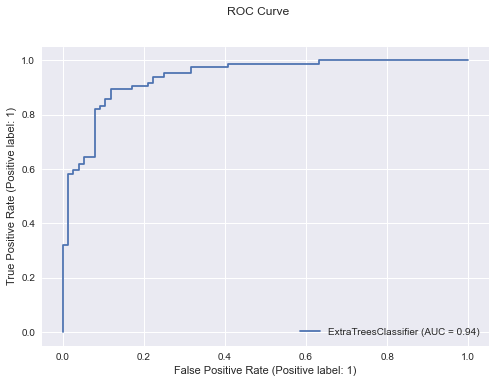

In [71]:
plt.style.use('seaborn')
disp = metrics.plot_roc_curve(final_model, x_test, y_test)
disp.figure_.suptitle("ROC Curve")
plt.show()

AUC score for my final model to be of 94%

**Confusion Matrix**

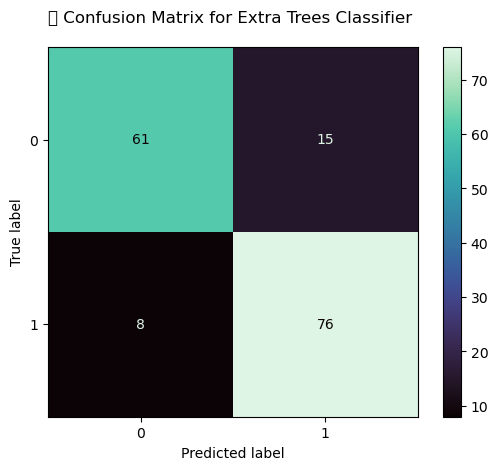

In [73]:
plt.style.use('default')
class_names = df.columns
metrics.plot_confusion_matrix(Classifier, x_test, y_test, cmap='mako')
plt.title('\t Confusion Matrix for Extra Trees Classifier \n')
plt.show()

This confusion matrix indicates that how many times my final model has failed to give the output(as shown in black box) and how many times it has predicted correct output

# Saving the Model

In [75]:
filename = "FinalModel_E06.pkl"
joblib.dump(final_model, filename)

['FinalModel_E06.pkl']

# Thank You for Evaluating My Project